### 6610402230 Sirisuk Tharntham

## Assignment 10: BERT


In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1K0VgdwYagNidu5k_y5pnSrGrGIOBPsyS' -O Fastfood_Opinion.csv

/usr/bin/zsh: /home/sk/anaconda3/envs/dl_env/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
--2024-09-16 11:52:45--  https://docs.google.com/uc?export=download&id=1K0VgdwYagNidu5k_y5pnSrGrGIOBPsyS
Resolving docs.google.com (docs.google.com)... 142.250.199.46, 2404:6800:4001:808::200e
Connecting to docs.google.com (docs.google.com)|142.250.199.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1K0VgdwYagNidu5k_y5pnSrGrGIOBPsyS&export=download [following]
--2024-09-16 11:52:45--  https://drive.usercontent.google.com/download?id=1K0VgdwYagNidu5k_y5pnSrGrGIOBPsyS&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 216.58.200.1, 2404:6800:4001:80a::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|216.58.200.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348315 (340K) [application/oc

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [3]:
df = pd.read_csv("Fastfood_Opinion.csv")
print(df.head())
print(df.shape)

   class                                            message
0      0  11.30 น. ไปที่สาขาในปั๊มคาลเท็กซ์ ประชานุกูล ซ...
1      0  BK ทุกสาขาบริการดี โดยเฉพาะอย่างยิ่งเอมโพเรียม...
2      0  Burger King สาขา The Bright พระราม 2 บริการห่ว...
3      0  Burger King สาขาปั้ม ป.ต.ท.บ้านพร อ.ถลาง เมื่อ...
4      0  chicken strip ชิ้นเล็กมาก เทียบกับป้ายโฆษณาบนโต๊ะ
(642, 2)


In [4]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['message'], df['class'],
                                                                    random_state=7777,
                                                                    test_size=0.3,
                                                                    stratify=df['class'])

print('train_text shape =',train_text.shape)
print('temp_text shape =',temp_text.shape)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=7777,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

print('val_text shape =',val_text.shape)
print('test_text shape =',test_text.shape)

train_text shape = (449,)
temp_text shape = (193,)
val_text shape = (96,)
test_text shape = (97,)


#### Use Model
bert-base-uncased

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
#-Tokenizing (splitting strings in sub-word token strings), converting tokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
#-Adding new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
#-Managing special tokens
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/home/sk/anaconda3/envs/dl_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Tokenization

<Axes: >

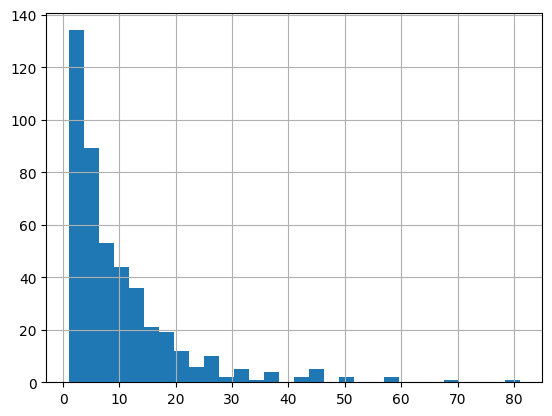

In [6]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

Limit Max Sequence Length 

In [7]:
max_seq_len = 30

In [8]:
# tokenize and encode sequences in the training set
# Parameters max_length = The maximum length (in number of tokens) for the inputs to the transformer model

# tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/sk/anaconda3/envs/dl_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors


In [9]:
#3 input of multihead attention including
#1.key = ids
#2.query = attention_mask
#3.value = label (0,1)
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Pre Setting
#### Freeze pretrain layer

In [11]:
#freeze all the parameters if unfreeze comment this block

for param in bert.parameters():
   param.requires_grad = False

# Define Model Architecture

In [12]:
class BERT_Arch(nn.Module):
# Applies a linear transformation to the incoming data:
# Parameters in_features – size of each input sample and out_features – size of each output sample

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [13]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
myModel = model.to(device)

In [14]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(myModel.parameters(), lr = 1e-3)

/home/sk/anaconda3/envs/dl_env/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weight

In [15]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights for unbalanced datasets
class_wts = compute_class_weight('balanced', classes= np.unique(train_labels), y= train_labels)

print(class_wts)

[0.89442231 1.13383838]


In [16]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine Tuning 

In [17]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [18]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Training

In [19]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()


    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.788
Validation Loss: 0.695

 Epoch 2 / 10

Evaluating...

Training Loss: 0.653
Validation Loss: 0.619

 Epoch 3 / 10

Evaluating...

Training Loss: 0.656
Validation Loss: 0.612

 Epoch 4 / 10

Evaluating...

Training Loss: 0.644
Validation Loss: 0.583

 Epoch 5 / 10

Evaluating...

Training Loss: 0.612
Validation Loss: 0.578

 Epoch 6 / 10

Evaluating...

Training Loss: 0.629
Validation Loss: 0.603

 Epoch 7 / 10

Evaluating...

Training Loss: 0.617
Validation Loss: 0.563

 Epoch 8 / 10

Evaluating...

Training Loss: 0.587
Validation Loss: 0.689

 Epoch 9 / 10

Evaluating...

Training Loss: 0.635
Validation Loss: 0.621

 Epoch 10 / 10

Evaluating...

Training Loss: 0.634
Validation Loss: 0.610


In [20]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

/tmp/ipykernel_12431/1604008560.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [21]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [22]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        54
           1       0.58      0.51      0.54        43

    accuracy                           0.62        97
   macro avg       0.61      0.61      0.61        97
weighted avg       0.62      0.62      0.62        97



In [23]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,38,16
1,21,22
